In [1]:
import sys
sys.path.append('..')
import alfw
from alfw import Face, lmnames, goodmarksnames, split
import numpy as np
import matplotlib.pyplot as plt
import skimage
%matplotlib inline

from keras.initializations import *
from keras.models import Model
from keras.layers import Dropout, Activation, Flatten, Dense, Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Merge, Reshape, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.objectives import mean_squared_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ProgbarLogger, EarlyStopping
from keras import backend as K
import keras
from theano.sandbox.cuda.dnn import *
import sklearn.metrics
import scipy

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Quadro K5200 (CNMeM is disabled, cuDNN 5005)


 ### Predicting gender with KERAS => https://keras.io/ 
 
 #### Improve the network
 
 accuracy to beat : 0.88
 
  - add layers
  - modify training params (learning rate, optimizer)
  - modify loss fct (hinge)
  - augment data
 
 #### Visualization
 
  - Print weights of conv layers
  - Visualize feature maps => https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb 
  - Implement CAM to visualize which areas of faces are most discriminative wrt gender => https://github.com/jacobgil/keras-cam 
  
 

In [2]:
Xtrain, ytrain, ht, mm, Xtest, ytest, hts, mmt, (mean, std, meany, stdy, meani, stdi), scale, unscale, d = alfw.prepare(200000, onlyvisible=False)
print 'ytrain ', ytrain.shape    
print Xtrain.shape

print 'mean ', np.mean(Xtrain, axis=3).shape

# to grey
Xtrain = np.mean(Xtrain, axis=3).reshape(Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2], 1)
Xtest = np.mean(Xtest, axis=3).reshape(Xtest.shape[0], Xtest.shape[1], Xtest.shape[2], 1)
Xtest1 = Xtest

# normalize between 0 , 1
Xtrain, ytrain, ht = scale( Xtrain, ytrain, ht )
Xtest, ytest, hts = scale( Xtest, ytest, hts )
print Xtrain.shape

loading..
im.shape:  (21776, 128, 128, 3)
feats.shape: (21776, 28, 2)
hogs.shape: (21776, 8100)
8166 21776
ytrain.shape  (19598, 12, 2)
ytrain  (19598, 12, 2)
(19598, 128, 128, 3)
mean  (19598, 128, 128)
(19598, 128, 128, 1)


In [3]:
print Xtrain.shape

(19598, 128, 128, 1)


(128, 128, 3)


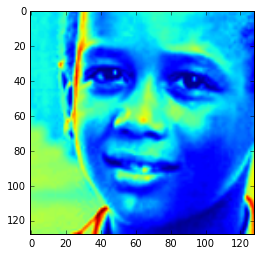

In [16]:
plt.imshow(Xtrain[12,:,:,0])
thick = lambda x : np.asarray([x,x,x]).transpose(1,2,0).astype(float)
print thick(Xtrain[12,:,:,0]).shape
n = Xtrain.shape[0]
n = 15000
for i in range(n):
    scipy.misc.imsave("/home/wp01/tmp/gen/faces/f" + str(i).zfill(4) + ".png", thick(Xtrain[i,:,:,0]))

## classification gender

play with data augmentation
cnn structure (maxpooling, conv layers)

In [4]:
print len(d['md'][0]) # describe faces of the training set ( #1 => val set)
face12 = d['md'][0][12]
print face12
roll = [face.roll for face in d['md'][0]]
print len(roll)

7349
Face(genre=u'f', roll=0.51872730255127, pitch=-0.158842504024506, yaw=-0.127118334174156, feats=array([[  11.1790393 ,   54.21834061],
       [  19.00436681,   39.68558952],
       [  41.92139738,   33.5371179 ],
       [  58.68995633,   25.15283843],
       [  76.01746725,   13.97379913],
       [  87.75545852,   16.20960699],
       [  23.47598253,   54.77729258],
       [  30.74235808,   48.62882096],
       [  39.68558952,   46.95196507],
       [  68.7510917 ,   34.65502183],
       [  75.45851528,   29.06550218],
       [  84.40174672,   27.38864629],
       [  17.88646288,   89.99126638],
       [  59.2489083 ,   70.98689956],
       [  68.7510917 ,   62.60262009],
       [  78.25327511,   62.04366812],
       [ -10.        ,  -10.        ],
       [  57.5720524 ,   91.10917031],
       [  74.34061135,   82.72489083],
       [  89.43231441,   77.13537118],
       [  83.84279476,  108.43668122],
       [ -10.        ,  -10.        ],
       [ -10.        ,  -10.        ],
  

In [9]:
genders = np.asarray([x.genre == 'f' for x in d['md'][0]])
genders_test = np.asarray([x.genre == 'f' for x in d['md'][1]])
print genders[20:]*1
print genders.shape

[1 1 0 ..., 1 1 0]
(7349,)


### Convolutional layers
<img src="http://rennsrdtacmapp05/wp01/www/assets/conv2D.PNG" width="50%" height="50%">

Relu activation : $ a(x) = max(0, x) $ 


In [10]:
# simple network
# input is 2D grey scale
inputs = Input((1, alfw.size, alfw.size))
conv01 = Convolution2D(32, 5, 5, subsample=(2,2), activation='relu')(inputs)
mp2 = MaxPooling2D((2,2))(conv01)
f = Flatten()(mp2)

### the sigmoid to predict pobabilities
<img src="http://rennsrdtacmapp05/wp01/www/assets/sigmoid1.png">

In [11]:
h1 = Dense(1, activation='sigmoid')(f)
modelGender = Model(input=inputs, output=h1)
sgd = SGD(lr=0.0051, momentum=0.9, nesterov=True, decay=1e-6)

## Keras built-in loss func (regression, classif ..)
Binary cross-entropy :
$ - p * log(y) + (1-p) log(1-y) $
<img src="http://rennsrdtacmapp05/wp01/www/assets/binary-cross-entropy.png">

Accuracy : $ (TP+TN) / (P+N)$

In [15]:
modelGender.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelGender.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1, 128, 128)   0                                            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 62, 62)    832         input_2[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 32, 31, 31)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 30752)         0           maxpooling2d_2[0][0]             
___________________________________________________________________________________________

In [16]:
history = modelGender.fit(np.transpose(Xtrain, (0, 3, 1, 2)),
                    (genders*1).astype(np.float32),
                    batch_size=128,
                    nb_epoch=10, verbose=1, shuffle=True,
                    validation_split = 0.3)

Train on 5144 samples, validate on 2205 samples
Epoch 1/10
5144/5144 [==============================] - 1s - loss: 0.9085 - acc: 0.5717 - val_loss: 0.6896 - val_acc: 0.5510
Epoch 2/10
5144/5144 [==============================] - 1s - loss: 0.6850 - acc: 0.5712 - val_loss: 0.6857 - val_acc: 0.5510
Epoch 3/10
5144/5144 [==============================] - 1s - loss: 0.6770 - acc: 0.5712 - val_loss: 0.6800 - val_acc: 0.5510
Epoch 4/10
5144/5144 [==============================] - 1s - loss: 0.6593 - acc: 0.5830 - val_loss: 0.6602 - val_acc: 0.5732
Epoch 5/10
5144/5144 [==============================] - 1s - loss: 0.6173 - acc: 0.6777 - val_loss: 0.6301 - val_acc: 0.6535
Epoch 6/10
5144/5144 [==============================] - 1s - loss: 0.5825 - acc: 0.7035 - val_loss: 0.6212 - val_acc: 0.6635
Epoch 7/10
5144/5144 [==============================] - 1s - loss: 0.5681 - acc: 0.7098 - val_loss: 0.6176 - val_acc: 0.6662
Epoch 8/10
5144/5144 [==============================] - 1s - loss: 0.5575 - a

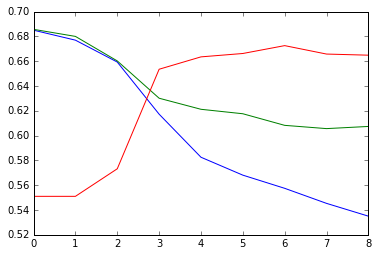

In [17]:
history.history
plt.plot(history.history['loss'][1:], color='blue', label='train')
plt.plot(history.history['val_loss'][1:], color='green' )
plt.plot(history.history['val_acc'][1:], color='red' )


(array([ 365.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  452.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

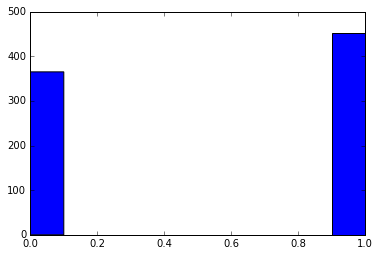

In [18]:
plt.hist(genders_test*1)

(817,)
accuracy 0.725597042066
0.676866585067


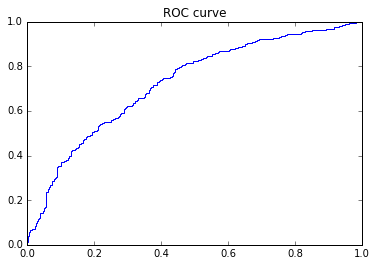

In [19]:
predtest = modelGender.predict(np.transpose(Xtest, (0, 3, 1, 2)))[:,0]
print predtest.shape
print 'accuracy',  sklearn.metrics.roc_auc_score(genders_test * 1 , predtest)
print sklearn.metrics.accuracy_score(genders_test * 1 , predtest>0.5)
fp, tp, _ = sklearn.metrics.roc_curve(genders_test * 1 , predtest)
plt.title('ROC curve')
plt.plot(fp, tp)



In [20]:
print Xtest.shape
modelGender.predict(np.transpose(Xtest[31:32,:,:,:], (0, 3, 1, 2)))
print genders_test[31]*1

(817, 128, 128, 1)
0


(1, 1, 128, 128)

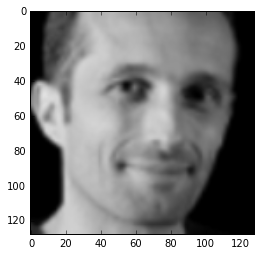

In [21]:
fn = '../data/cg.PNG'
fn = '../data/pp.png'

pp = scipy.misc.imread(fn)
pp = pp[:,:,0:3]
pp = scipy.misc.imresize(pp, (128,128))
plt.imshow(pp[:,:,0:3])
pp = np.mean(pp, axis=2, keepdims=True)

np.transpose([pp], (0, 3, 1, 2)).shape

## the average man

improve the prediction

In [27]:
tX = np.transpose([pp], (0, 3, 1, 2))
'this a ' + {0 : "man", 1 : "woman"}[int(modelGender.predict(tX)>0.5)]

'this a woman'

## Bonus


In [30]:
# get intermediate output
layer = K.function([modelGender.layers[0].input],
                                  [modelGender.layers[1].output])
layer_output = layer([tX])[0]
print layer_output.shape

(1, 32, 62, 62)


In [35]:
print modelGender.layers[1].weights

[convolution2d_2_W, convolution2d_2_b]


## CAM
<img src="http://rennsrdtacmapp05/wp01/www/assets/cam.PNG">

<img src="http://rennsrdtacmapp05/wp01/www/assets/cam-formulation.PNG">




https://jacobgil.github.io/deeplearning/class-activation-maps